In [1]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
#from scipy.misc import imsave
from matplotlib.pyplot import imsave
from scipy.misc import imresize
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf

In [2]:
from layers.data_utils import get_CIFAR10_grayscale

# Load the (preprocessed) CIFAR10 data.
x_train, y_train, _, _, _, _ = get_CIFAR10_grayscale(num_training=100, num_validation=0, num_test=0,
                     subtract_mean=False)
print(np.shape(x_train))
print(np.shape(y_train))

(100, 32, 32)
(100,)


3
0.986928104575


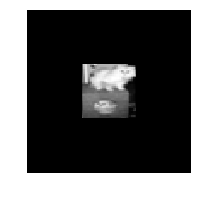

(96, 96)


In [3]:
i = np.random.randint(0, 100)
I = x_train[i,:,:]

# plt.imshow(I, cmap='gray')
# plt.axis('off')
# plt.gcf().set_size_inches(2, 2)
# plt.show()
print(y_train[i])
print(np.max(I))

# pad image
# I = imresize(I, (28,28))
pad_amt = 32
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0))
plt.imshow(Ipad, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

print(np.shape(Ipad))

### Extract weights from checkpoint

In [4]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

def print_tensors_in_ckpt(ckpt_path):
    print_tensors_in_checkpoint_file(ckpt_path, 
                                          tensor_name='', all_tensors=False)
    
def load_variable_from_checkpoint(tensor_name, shape, ckpt_path, dtype=tf.float64):
    tf.reset_default_graph()

    # Load checkpoint from disk to compare phase shifts found by tensorflow
    tensor_graph = tf.get_variable(tensor_name, shape=shape, dtype=dtype)
    with tf.Session() as sess:
        saver = tf.train.Saver([tensor_graph])
        saver.restore(sess, ckpt_path)
        
        tensor_value = sess.run(tensor_graph)

    return tensor_value

In [5]:
nn_ckpt_path = '/media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000' # fabrication
# nn_ckpt_path = '/media/data/checkpoints/onn/hybrid_cifar10/optneg/20180307-105014/model.ckpt-15000'
print_tensors_in_ckpt(nn_ckpt_path)

Variable (DT_INT32) []
W_fc1 (DT_FLOAT) [8192,10]
W_fc1/Adam (DT_FLOAT) [8192,10]
W_fc1/Adam_1 (DT_FLOAT) [8192,10]
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
conv1/W_conv1_neg (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_neg/Adam (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_neg/Adam_1 (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_pos (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_pos/Adam (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_pos/Adam_1 (DT_FLOAT) [9,9,1,8]
conv1/b_conv1 (DT_FLOAT) [8]
conv1/b_conv1/Adam (DT_FLOAT) [8]
conv1/b_conv1/Adam_1 (DT_FLOAT) [8]
fc/b_fc1 (DT_FLOAT) [10]
fc/b_fc1/Adam (DT_FLOAT) [10]
fc/b_fc1/Adam_1 (DT_FLOAT) [10]



INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000


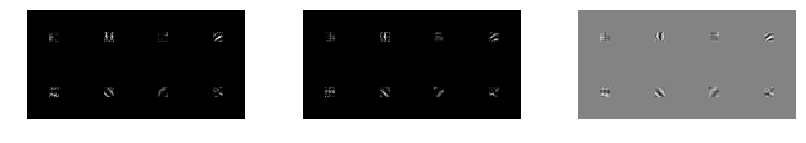

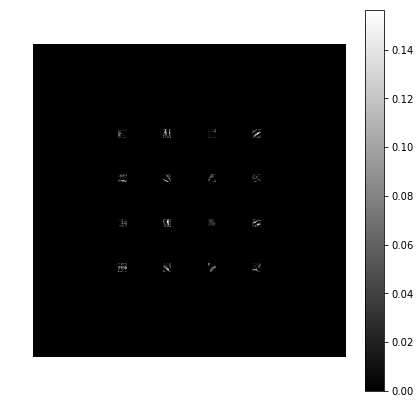

0.0 0.156099 (328, 328)


In [6]:
convdim = 9
depth = 8
pad = (48-convdim)//2
rows = 2
cols = 4

varname = 'conv1/W_conv1_pos'
var1 = load_variable_from_checkpoint(varname, [convdim,convdim,1,depth], nn_ckpt_path, dtype=tf.float32)
W_conv1_pos = np.abs(var1.squeeze())

varname = 'conv1/W_conv1_neg'
var2 = load_variable_from_checkpoint(varname, [convdim,convdim,1,depth], nn_ckpt_path, dtype=tf.float32)
W_conv1_neg = np.abs(var2.squeeze())


kernels_pos_pad = [np.pad(W_conv1_pos[:,:,i], (pad,pad), 'constant') for i in range(depth)]
psf_pos = np.concatenate(
    [np.concatenate((kernels_pos_pad[i*cols:(i+1)*cols]), axis=1) for i in range(rows)], axis=0)
kernels_neg_pad = [np.pad(W_conv1_neg[:,:,i], (pad,pad), 'constant') for i in range(depth)]
psf_neg = np.concatenate(
    [np.concatenate((kernels_neg_pad[i*cols:(i+1)*cols]), axis=1) for i in range(rows)], axis=0)


psf_sub = psf_pos - psf_neg
fig, ax = plt.subplots(nrows=1, ncols=3)
plt.subplot(131)
plt.imshow(psf_pos, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(psf_neg, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(psf_sub, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(14, 2)
plt.show()

extra_pad = 70# 100#  int(.5*np.shape(psf)[0])
psf = np.concatenate((psf_pos, psf_neg), axis=0)
psf = np.pad(psf, (extra_pad, extra_pad), 'constant')
dim = np.shape(psf)[0]

plt.imshow(psf, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.gcf().set_size_inches(7,7) 
plt.show()
# plt.savefig('W_conv1.png')

print(np.min(psf), np.max(psf), np.shape(psf))



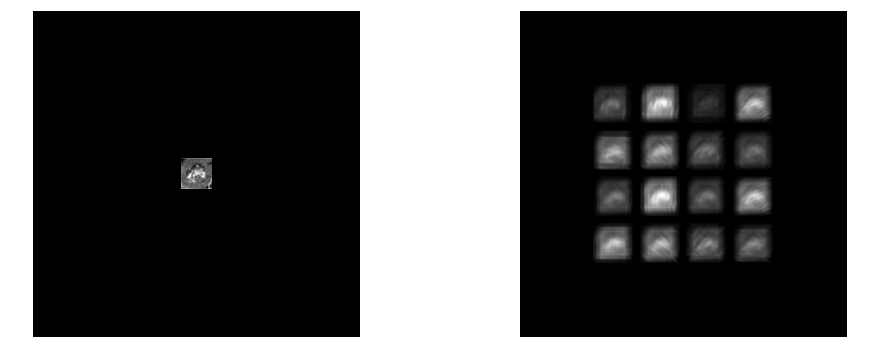

In [7]:
# example convolution
i = np.random.randint(0, 100)
i = 0
I = x_train[i,:,:]

pad_amt = (dim - 32)//2
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 

fig, ax = plt.subplots(nrows=1, ncols=2)
plt.subplot(121)
plt.imshow(Ipad, cmap='gray')
plt.axis('off')

#Ipad = np.zeros((84,84))
#Ipad[42,42] = 1

#Iconv = convolve(Ipad, psf, mode='constant')

# # convolve
otf = np.fft.fft2(np.fft.ifftshift(psf))
# plt.imshow(np.square(np.fft.fftshift(np.abs(otf))), cmap='gray')
# plt.axis('off')
# plt.gcf().set_size_inches(3, 3)
# plt.show()

Ift = np.fft.fft2(Ipad)
Iconv = np.abs(np.fft.ifft2(Ift*otf))

plt.subplot(122)
plt.imshow(Iconv, cmap='gray')
plt.axis('equal')
plt.axis('off')

# # calculate scores
# Iconv_vsplit = np.vsplit(Iconv, 3)
# Iconv_split = np.concatenate((np.hsplit(Iconv_vsplit[0], 3), 
#                              np.hsplit(Iconv_vsplit[1], 3), 
#                              np.hsplit(Iconv_vsplit[2], 3)), axis=0)
# scores = np.max(Iconv_split, axis=(1,2))
# plt.subplot(133)
# plt.imshow(np.reshape(scores, [3,3]), cmap='gray')
# plt.axis('off')

# print(scores)
# print(np.argmax(scores))

plt.gcf().set_size_inches(16, 6)
plt.show()

imsave('cifar10.png', Iconv, cmap='gray')

In [9]:
np.save('maskopt/psf_hybrid_optneg_8x9_1e-1_figure.npy', psf)

(328, 328)


In [50]:
# generate training images for mask optimization
x_train, y_train, _, _ = get_CIFAR10_grayscale(num_training=10000, num_validation=0, num_test=0,
                     subtract_mean=False)
for i in range(10000):
    I = x_train[i,:,:]
    
    # pad image
    pad_amt = (dim - 32)//2
    Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 

    imsave('/media/data/onn/cifar10padded_388/im_%05d.png' % (i), Ipad)


### Extract optimized phase mask

In [8]:
# version = 'optneg_8x9_4x/20180320-172415'
version = 'optneg_8x9_6x/20180319-141529'
ckpt_path = '/media/data/checkpoints/onn/hybrid_cifar10/maskopt/' + version + '/PhaseMask_ONN.ckpt-40000'
print_tensors_in_ckpt(ckpt_path)

Variable (DT_INT32) []
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
model/maskopt/phase_mask_height/height_map_sqrt (DT_DOUBLE) [1,1968,1968,1]
model/maskopt/phase_mask_height/height_map_sqrt/Adam (DT_DOUBLE) [1,1968,1968,1]
model/maskopt/phase_mask_height/height_map_sqrt/Adam_1 (DT_DOUBLE) [1,1968,1968,1]



INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/maskopt/optneg_8x9_6x/20180319-141529/PhaseMask_ONN.ckpt-40000
0.0267731298003 0.0 mean: 2.31015089417e-06


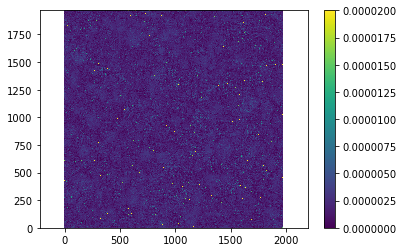

In [9]:
dim = 328
scale = 6
waveres = dim*scale
bHeightMap = True
if bHeightMap:
    varname = 'model/maskopt/phase_mask_height/height_map_sqrt'
    height_map_sqrt = load_variable_from_checkpoint(varname, [1,waveres,waveres,1], ckpt_path, dtype=tf.float64)
    height_map = np.square(height_map_sqrt.squeeze())        
    
else:
    varname = 'model/maskopt/zernike_element/zernike_coeffs'
    zernike_coeffs = load_variable_from_checkpoint(varname, [1024,1,1], ckpt_path, dtype=tf.float32)

    n_modes = 1024
    zernike_modes = np.load('zernike_volume_256.npy')[:n_modes,:,:]

    # zernike_modes = np.expand_dims(zernike_modes, -1)
    zernike_modes_rsz = np.zeros((n_modes,waveres,waveres))
    for i in range(n_modes):
        zernike_modes_rsz[i,:,:] = np.expand_dims(imresize(np.squeeze(zernike_modes[i,:,:]), (waveres, waveres)), 0)
    # zernike_modes = np.squeeze(zernike_modes, -1)

    print(np.max(zernike_modes))
    height_map = np.sum(zernike_coeffs*zernike_modes_rsz, axis=0)
    # height_map = np.expand_dims(tf.expand_dims(height_map, 0), -1)
    # height_map = circular_aperture(height_map, max_val = r_NA)
    height_map = np.moveaxis(height_map, 0, -1)
    
print(np.max(height_map), np.min(height_map), 'mean:', np.mean(height_map))
plt.pcolor(height_map, vmin=0, vmax=2e-5)
plt.colorbar()
plt.axis('equal')
plt.show()

In [53]:
addHeightNoise = False
# add variation to the height map
if addHeightNoise:
    height_noise = 1.0*(np.zeros((scale*dim,scale*dim)))
    width = 1
    step = 32
    noisemax = 50e-9
    # set lattice to 0
    for i in range(8, scale*dim, step):
        for j in range(8, scale*dim, step):
            height_noise[i:i+step,j:j+step] = np.random.rand(1)*noisemax
    plt.pcolor(height_noise, vmin=0, vmax=noisemax)
    plt.colorbar()
    plt.axis('equal')
    plt.show()
    
    height_map = height_map + height_noise

(1968, 1968) ()
(328, 328)


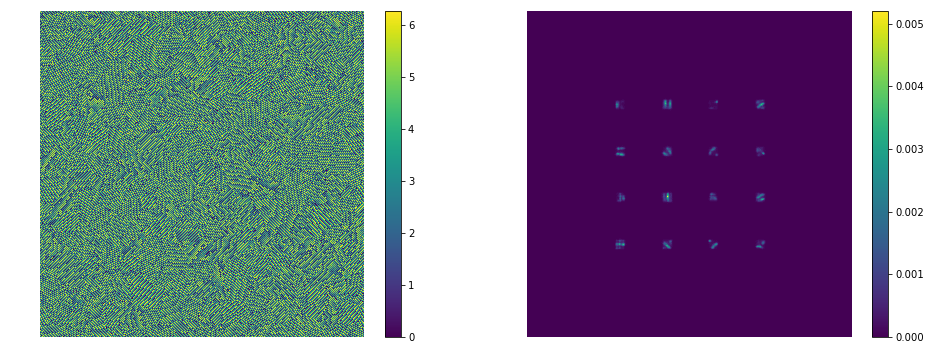

In [10]:
# Visualize phase mask instead
wavelength = 532 * 1e-9
n = 1.5090
delta_n = n - 1.0002777
phi = (2*np.pi*delta_n/wavelength) * height_map
phimax = 2*np.pi;
phi = np.mod(phi, phimax)


# [x, y] = np.mgrid[-waveres//2: waveres//2, -waveres//2: waveres//2].astype(np.float64)
# max_val = 300# np.amax(35)
# r = np.sqrt(x ** 2 + y ** 2)
aperture_mask = 1# r<max_val
print(np.shape(phi), np.shape(aperture_mask))
atf = np.fft.ifftshift(aperture_mask * np.exp(1j*phi))

doBinaryMask=False
if doBinaryMask:
    binary_mask = np.load('maskopt/latticemask_8umgap_8x328_2umpix.npy')
    atf = atf * binary_mask

psf_pm_full = np.square(np.abs(np.fft.ifft2(atf)))
psf_pm_full = np.fft.fftshift(psf_pm_full)
#psf_pm_full = np.flipud(np.fliplr(psf_pm_full))

psf_pm = imresize(psf_pm_full, (dim, dim))
psf_pm = psf_pm/np.sum(psf_pm)
print(np.shape(psf_pm))

# plot
fig, ax = plt.subplots(nrows=1, ncols=2)

plt.subplot(121)
plt.pcolor(phi, vmin=0, vmax=phimax)
plt.colorbar()
plt.axis('equal')
plt.axis('off')

plt.subplot(122)
plt.imshow(psf_pm)
plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.gcf().set_size_inches(16, 6)
plt.show()

In [55]:
imsave('h/pm_phase.png', phi/np.max(phi),cmap='gray')
imsave('h/pm_psf.png', psf_pm_full/np.max(psf_pm_full), cmap='gray')
imsave('h/pm_psf_subsampled.png', psf_pm/np.max(psf_pm), cmap='gray')
print(np.shape(height_map), np.shape(phi))
np.savetxt('h/pm_height.txt', height_map)
np.save('h/pm_height.npy', height_map)
np.savetxt('h/pm_phase.txt', phi)
np.save('h/pm_phase.npy', phi)

(2624, 2624) (2624, 2624)


2.38904791945 0.106751760646
0.0808338466579 0.00356810109529


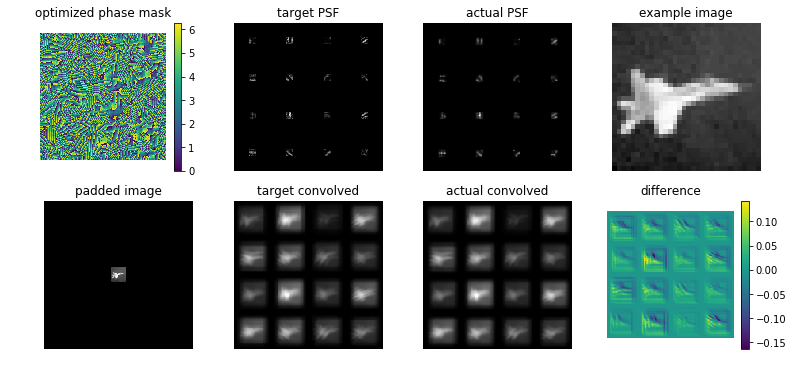

In [11]:
# Test phase mask
i = np.random.randint(0, 100)
I = x_train[i,:,:]

pad_amt = (dim - 32)//2
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0))

# I = np.zeros((84,84))
# I[44:45,30:60]=1
# I[30:60,44]=1
#Ift = np.fft.fft2(I)

unpad = extra_pad

fig, ax = plt.subplots(nrows=2, ncols=4)
plt.subplot(241)
plt.pcolor(phi, vmin=0, vmax=phimax)
plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.title('optimized phase mask')

plt.subplot(242)
plt.imshow(psf[unpad:-unpad, unpad:-unpad], cmap='gray')
plt.axis('off')
plt.title('target PSF')

plt.subplot(243)
plt.imshow(psf_pm[unpad:-unpad, unpad:-unpad], cmap='gray')
plt.axis('off')
plt.title('actual PSF')

plt.subplot(244)
plt.imshow(I, cmap='gray')
plt.axis('off')
plt.title('example image')

plt.subplot(245)
plt.imshow(Ipad, cmap='gray')
plt.axis('off')
plt.title('padded image')

# convolve
# otf = np.fft.fft2(np.fft.ifftshift(psf))
# Iconv = np.abs(np.fft.ifft2(np.fft.fft2(Ipad)*otf))
Iconv = fftconvolve(Ipad, psf, mode='same')

# otf_pm = np.fft.fft2(np.fft.ifftshift(psf_pm))
# Iconv_pm = np.abs(np.fft.ifft2(np.fft.fft2(Ipad)*otf_pm))
Iconv_pm = fftconvolve(Ipad, psf_pm, mode='same')

Iconv_diff = Iconv/np.max(Iconv) - Iconv_pm/np.max(Iconv_pm)
print(np.max(Iconv), np.mean(Iconv))
print(np.max(Iconv_pm), np.mean(Iconv_pm))

plt.subplot(246)
plt.imshow(Iconv[unpad:-unpad, unpad:-unpad], cmap='gray')
plt.axis('off')
plt.title('target convolved')

plt.subplot(247)
plt.imshow(Iconv_pm[unpad:-unpad, unpad:-unpad], cmap='gray')
plt.axis('off')
plt.title('actual convolved')

plt.subplot(248)
plt.pcolor(Iconv_diff[unpad:-unpad, unpad:-unpad]), plt.colorbar()
plt.axis('equal')
plt.axis('off')
plt.title('difference')

plt.gcf().set_size_inches(13, 6)
plt.show()
# plt.savefig('hybrid_maskopt.png')

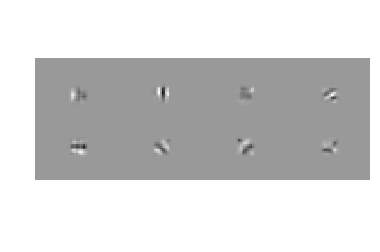

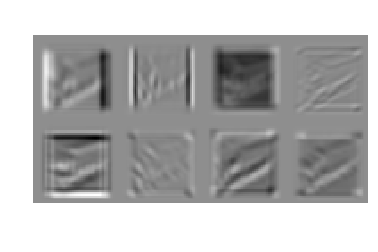

-0.25052135275 -1.7069125918


In [56]:
# just for visualization
psf_unpad = psf_pm[unpad:-unpad, unpad:-unpad]
dim_unpad = np.shape(psf_unpad)[0]
psf_sub = psf_unpad[:int(dim_unpad/2), :] - psf_unpad[int(dim_unpad/2):, :]
crop = 4
psf_sub = np.concatenate((psf_sub[crop:np.shape(psf_sub)[0]//2-crop-5, :], 
                          psf_sub[np.shape(psf_sub)[0]//2+crop+5:-crop, :]), axis=0)

plt.imshow(psf_sub, cmap='gray')
plt.axis('equal')
plt.axis('off')
plt.show()

Iconv_unpad = Iconv_pm[unpad:-unpad, unpad:-unpad]
Iconv_sub = Iconv_unpad[:int(dim_unpad/2), :] - Iconv_unpad[int(dim_unpad/2):, :]

plt.imshow(Iconv_sub, cmap='gray')
plt.axis('equal')
plt.axis('off')
plt.show()

tile_size = 47
h_pad1 = int(np.ceil((tile_size-32)/2))
h_pad2 = int(np.floor((tile_size-32)/2))
h_conv1_split1d = np.array_split(Iconv_unpad, 2*rows, axis=0)
h_conv1_split2d = np.concatenate([np.array_split(h_conv1_split1d[i], cols, axis=1) for i in range(2*rows)], axis=0)
h_conv1_both = np.transpose(h_conv1_split2d[:, h_pad1:-h_pad2, h_pad1:-h_pad2], (1, 2, 0)) 
h_conv1_subtracted = h_conv1_both[:,:,:depth] - h_conv1_both[:,:,depth:]
# print(np.max(h_conv1_subtracted, axis=(0,1)))
h_conv1_subtracted /= np.max(h_conv1_subtracted)

print(np.mean(h_conv1_subtracted), np.min(h_conv1_subtracted))


In [14]:
# save phase mask
# np.save('maskopt/hm_sqrt_optneg_8x9_640.npy', height_map_sqrt)
# np.save('maskopt/quickdraw9_zernike1024.npy', zernike_coeffs)

from matplotlib.pyplot import imsave
imsave('pm_phase.png', phi/np.max(phi), cmap='inferno')
imsave('pm_psf.png', psf_pm[unpad:-unpad, unpad:-unpad], cmap='gray')
imsave('Iconv.png', Iconv_unpad, cmap='gray')
imsave('Ipad.png', Ipad[unpad:-unpad, unpad:-unpad], cmap='gray')
imsave('pm_psf_sub.png', psf_sub, cmap='gray')

for i in range(0):
    h = h_conv1_subtracted[:,:,i]
    imsave('h/h_sub_%d.png' % i, h, vmin=-.7, vmax=.26, cmap='gray')
    
    plt.imshow(h, vmin=-.7, vmax=.26, cmap='gray')
    plt.axis('equal')
    plt.axis('off')
    plt.show()

# Classification

In [12]:
# attempt to classify
print_tensors_in_ckpt(nn_ckpt_path)

Variable (DT_INT32) []
W_fc1 (DT_FLOAT) [8192,10]
W_fc1/Adam (DT_FLOAT) [8192,10]
W_fc1/Adam_1 (DT_FLOAT) [8192,10]
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
conv1/W_conv1_neg (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_neg/Adam (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_neg/Adam_1 (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_pos (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_pos/Adam (DT_FLOAT) [9,9,1,8]
conv1/W_conv1_pos/Adam_1 (DT_FLOAT) [9,9,1,8]
conv1/b_conv1 (DT_FLOAT) [8]
conv1/b_conv1/Adam (DT_FLOAT) [8]
conv1/b_conv1/Adam_1 (DT_FLOAT) [8]
fc/b_fc1 (DT_FLOAT) [10]
fc/b_fc1/Adam (DT_FLOAT) [10]
fc/b_fc1/Adam_1 (DT_FLOAT) [10]



In [13]:
b_conv1 = load_variable_from_checkpoint('conv1/b_conv1', [8], nn_ckpt_path, dtype=tf.float32)
W_fc1 = load_variable_from_checkpoint('W_fc1', [8192, 10], nn_ckpt_path, dtype=tf.float32)
b_fc1 = load_variable_from_checkpoint('fc/b_fc1', [10], nn_ckpt_path, dtype=tf.float32)


INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000


In [14]:
def predict_class_kernels(I, W_conv1_pos, W_conv1_neg): 
    # convolve with W_conv1
    W_conv1 = W_conv1_pos - W_conv1_neg
    
    small_pad_amt = 16
    I_pad = np.pad(I, ((small_pad_amt, small_pad_amt)), 'constant', constant_values = (0,0))    
    h_conv1 = np.zeros((32, 32, depth))
    for d in range(depth):
        kernel = np.pad(W_conv1[:,:,d], ((small_pad_amt, small_pad_amt)), 'constant', constant_values = (0,0))
        curr_conv = fftconvolve(I_pad, kernel, mode='same')
        h_conv1[:,:,d] = curr_conv[small_pad_amt:-small_pad_amt, small_pad_amt:-small_pad_amt]
        # h_conv1[:,:,d] = convolve(I, W_conv1[:,:,d], mode='constant')
        

    h_conv1 /= np.max(h_conv1)
    # print(np.mean(h_conv1, axis=(0,1)))
    h_conv1 = h_conv1 + b_conv1
    np.maximum(0, h_conv1, h_conv1)
    # print(np.shape(h_conv1))

    # feed to FC layer
    h_conv1_flat = np.reshape(h_conv1, 32*32*depth)
    y_out = np.matmul(h_conv1_flat, W_fc1) + b_fc1

    return y_out

def predict_class(I, psf): 
    # convolve with W_conv1
    pad_amt = (dim - 32)//2
    Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 

    Iconv = fftconvolve(Ipad, psf, mode='same')

    #Iconv_pm = np.abs(np.fft.ifft2(np.fft.fft2(Ipad)*otf_pm))

    tile_size = 47
    h_pad1 = int(np.ceil((tile_size-32)/2))
    h_pad2 = int(np.floor((tile_size-32)/2))

    h_conv1_tiled = Iconv[unpad:-unpad, unpad:-unpad]
    h_conv1_split1d = np.array_split(h_conv1_tiled, 2*rows, axis=0)
    h_conv1_split2d = np.concatenate([np.array_split(h_conv1_split1d[i], cols, axis=1) for i in range(2*rows)], axis=0)
    h_conv1_both = np.transpose(h_conv1_split2d[:, h_pad1:-h_pad2, h_pad1:-h_pad2], (1, 2, 0)) 
    h_conv1_subtracted = h_conv1_both[:,:,:depth] - h_conv1_both[:,:,depth:]
    # print(np.max(h_conv1_subtracted, axis=(0,1)))
    h_conv1_subtracted /= np.max(h_conv1_subtracted)
    h_conv1 = h_conv1_subtracted + b_conv1
    np.maximum(0, h_conv1, h_conv1)
    # print(np.shape(h_conv1))

    # feed to FC layer
    h_conv1_flat = np.reshape(h_conv1, 32*32*depth)
    y_out = np.matmul(h_conv1_flat, W_fc1) + b_fc1

    return y_out

In [15]:
verbose = False
_, _, _, _, x_val, y_val = get_CIFAR10_grayscale(num_training=0, num_validation=0, num_test=1000,
                     subtract_mean=False)


In [22]:
n_val = 50
y_pred_tf = np.zeros(n_val)
y_pred_pm = np.zeros(n_val)
for i in range(n_val):
    #i = np.random.randint(0, 100)
    I = x_val[i,:,:]
    I = np.power(I, 2.2)
    
    y_out_pm = predict_class(I, psf_pm)
    y_out_tf = predict_class(I, psf)
    # y_out = predict_class_kernels(I, W_conv1_pos, W_conv1_neg)

    # make prediction
    y_pred_pm[i] = np.argmax(y_out_pm)
    y_pred_tf[i] = np.argmax(y_out_tf)

    if verbose:
        print('predicted: \t', y_pred_pm[i])
        print('actual: \t', y_val[i])
        
accuracy_pm = np.mean(np.equal(y_pred_pm, y_val[:n_val]))
accuracy_tf = np.mean(np.equal(y_pred_tf, y_val[:n_val]))
print('tf accuracy: \t', accuracy_tf)
print('pm accuracy: \t', accuracy_pm)

tf accuracy: 	 0.46
pm accuracy: 	 0.26


0.405512553185
-0.0936971089176
0.248706298195
0.294118857227
0.214502107903
-0.182775584854
0.24302496242
-0.106013280598
(320, 320)


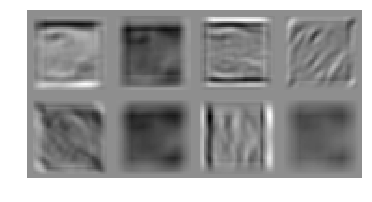

0.405512554097
-0.0936971098509
0.24870631016
0.294118871601
0.21450210973
-0.182775585058
0.243024958657
-0.106013280752


In [119]:
idx = 2

I = x_val[idx,:,:]
W_conv1 = W_conv1_pos - W_conv1_neg

# plt.imshow(I, cmap='gray')
# plt.axis('off')
# plt.show()
    
small_pad_amt = 16
I_pad = np.pad(I, ((small_pad_amt, small_pad_amt)), 'constant', constant_values = (0,0))    
h_conv1 = np.zeros((32, 32, depth))
for d in range(depth):
    kernel = np.pad(W_conv1[:,:,d], ((small_pad_amt, small_pad_amt)), 'constant', constant_values = (0,0))
    curr_conv = fftconvolve(I_pad, kernel, mode='same')
    h_conv1[:,:,d] = curr_conv[small_pad_amt:-small_pad_amt, small_pad_amt:-small_pad_amt]
    
    # plt.imshow(h_conv1[:,:,d], cmap='gray')
    # plt.axis('off')
    # plt.show()
    print(np.max(h_conv1[:,:,d]))
    
#####

Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 
Iconv = fftconvolve(Ipad, psf, mode='same')
print(np.shape(Iconv))

h_pad2 = int(np.floor((45-32)/2))
h_pad1 = int(np.ceil((45-32)/2))

h_conv1_tiled = Iconv[unpad:-unpad, unpad:-unpad]
plt.imshow(h_conv1_tiled[:90,:] - h_conv1_tiled[90:,:], cmap='gray')
plt.axis('off')
plt.show()

h_conv1_split1d = np.array_split(h_conv1_tiled, 2*rows, axis=0)
h_conv1_split2d = np.concatenate([np.array_split(h_conv1_split1d[i], cols, axis=1) for i in range(2*rows)], axis=0)
h_conv1_both = np.transpose(h_conv1_split2d[:, h_pad1:-h_pad2, h_pad1:-h_pad2], (1, 2, 0)) 
h_conv1_subtracted = h_conv1_both[:,:,:depth] - h_conv1_both[:,:,depth:]

for d in range(depth):
    print(np.max(h_conv1_subtracted[:,:,d]))
    


# # h_conv1 /= np.max(h_conv1)
# h_conv1 = h_conv1 # + b_conv1
# np.maximum(0, h_conv1, h_conv1)
# # print(np.shape(h_conv1))

# # feed to FC layer
# h_conv1_flat = np.reshape(h_conv1, 32*32*depth)
# y_out = np.matmul(h_conv1_flat, W_fc1)

# print('predicted: \t', np.argmax(y_out))
# print('actual: \t', y_val[idx])
        